In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [2]:
# Load DSM
dsm_2024_path = "../data/20240607_UAV-Photo_Sandhausen_dem_5cm_clipped.tif"
dsm_2025_path = "../data/20250613_UAV-Photo_Sandhausen_dem_clipped.tif"

In [3]:
# Reproject 2025 to match 2024 grid
with rasterio.open(dsm_2024_path) as ref:
    ref_meta = ref.meta.copy()
    ref_array = ref.read()
    
with rasterio.open(dsm_2025_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, ref_meta['crs'], ref_meta['width'], ref_meta['height'], *ref.bounds
    )
    dst_array = np.empty((ref_meta['height'], ref_meta['width']), dtype=ref_meta['dtype'])
    
    reproject(
        source=rasterio.band(src, 1),
        destination=dst_array,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=ref_meta['transform'],
        dst_crs=ref_meta['crs'],
        resampling=Resampling.bilinear
    )

In [36]:
print(ref_array[0].max(), ref_array[0].min())
ref_array.shape

189.49097 -32767.0


(1, 5383, 5994)

In [37]:
print(dst_array[0].max(), dst_array[0].min())
dst_array.shape

152.31383 -32767.0


(5383, 5994)

In [38]:
ref_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -32767.0,
 'width': 5994,
 'height': 5383,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["ETRS89 / UTM zone 32N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",9],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","25832"]]'),
 'transform': Affine(0.0499804150387428, 0.0, 473856.140938232,
        0.0, -0.049980415038753404, 5465338.690220014)}

In [4]:
dsm_2024 = np.copy(ref_array.squeeze())
dsm_2025 = np.copy(dst_array)
dsm_2024[dsm_2024 < 0] = 0
dsm_2025[dsm_2025 < 0] = 0

In [5]:
# Difference (positive = growth, negative = removal)
delta_dsm = dsm_2025 - dsm_2024

In [6]:
print(delta_dsm.max(), delta_dsm.min())

175.46936 -175.16646


In [45]:
# Save to GeoTIFF
out_path = "Delta_DSM_2025-2024.tif"
with rasterio.open(out_path, "w", **ref_meta) as dst:
    dst.write(delta_dsm, 1)

print(f"ΔDSM written to {out_path}")

ΔDSM written to Delta_DSM_2025-2024.tif


In [7]:
dsm_zscore = (delta_dsm - np.mean(delta_dsm)) / np.std(delta_dsm)
print(f"Z-score range: ~{np.min(dsm_zscore):.2f} to {np.max(dsm_zscore):.2f}")

Z-score range: ~-56.00 to 56.09


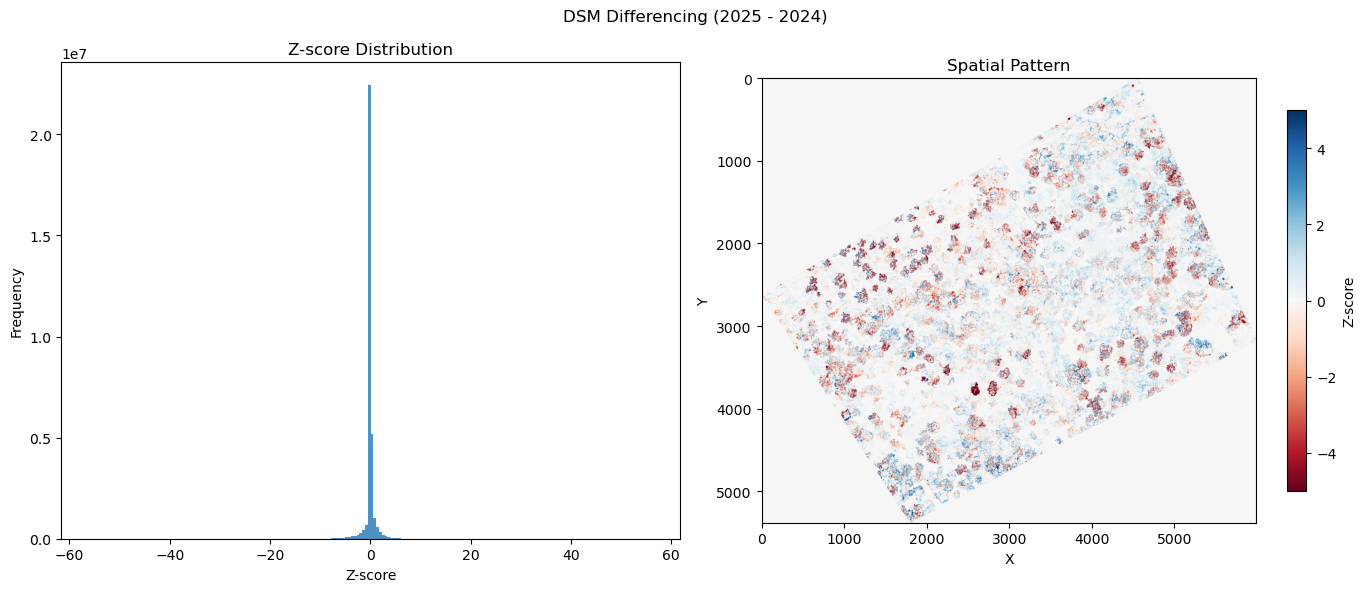

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Value distribution
ax1.hist(dsm_zscore.flatten(), bins=200, alpha=0.8)
ax1.set_xlabel("Z-score")
ax1.set_ylabel("Frequency")
ax1.set_title("Z-score Distribution")

# Spatial distribution
im = ax2.imshow(dsm_zscore, cmap="RdBu", vmin=-5, vmax=5)
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_title("Spatial Pattern")

cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar.set_label("Z-score")

fig.suptitle("DSM Differencing (2025 - 2024)")
plt.tight_layout()
plt.show()